# Problem 1

In [53]:
import pandas as pd
import numpy as np
import gurobipy as gp


In [55]:

# Load the dataset
advertising_data = pd.read_csv('HW2/Advertising Winter 2024.csv')
advertising_data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [56]:

# Preparing data for L1 regression
X = advertising_data[['TV', 'Radio', 'Newspaper']].values
y = advertising_data['Sales'].values

# Number of predictors
n = X.shape[0]




In [57]:

# Create a Gurobi model
model = gp.Model()
#setting params for gurobi for clean outtput
model.Params.OutputFlag = 0

# Add variables for regression coefficients
b0 = model.addVar(name='b0', vtype=GRB.CONTINUOUS)
b1 = model.addVar(name='b1', vtype=GRB.CONTINUOUS)
b2 = model.addVar(name='b2', vtype=GRB.CONTINUOUS)
b3 = model.addVar(name='b3', vtype=GRB.CONTINUOUS)


# Add variables for the L1 loss
loss = model.addVars(n, lb=0, name='loss', vtype=GRB.CONTINUOUS)

# Objective function: minimize the sum of the L1 loss
model.setObjective(sum(loss[i] for i in range(n)), GRB.MINIMIZE)

# Constraints for the L1 loss
for i in range(n):
    model.addConstr(loss[i] >= y[i] - (b0+ b1*X[i,0] + b2*X[i,1] + b3*X[i,2]) )
    model.addConstr(loss[i] >= -y[i] +( b0+ b1*X[i,0] + b2*X[i,1] + b3*X[i,2]) )

# Solve the model
model.optimize()

# Print the regression coefficients
print('b0 =', b0.x)
print('b1 =', b1.x)
print('b2 =', b2.x)
print('b3 =', b3.x)



b0 = 3.2797893774713356
b1 = 0.04382140799173407
b2 = 0.1967413118206927
b3 = 0.0


# Problem 2

It is, in general, a good idea to test a machine learning model on a simple
simulated test dataset to ensure the model works as intended. The make blobs function in
scikit-learn can be used to generate data-points simulated from multivariate normal dis-
tributions. Your first task is to use the make blobs function to generate 500 observations
(𝑥,𝑦)with two predictor variables and one outcome variable. Set centers = 2. For each
observation 𝑖, 𝑦𝑖denotes the class of observations it belongs to.


Visualize the data and visually identify whether the observations can be separated with
a linear classifier.

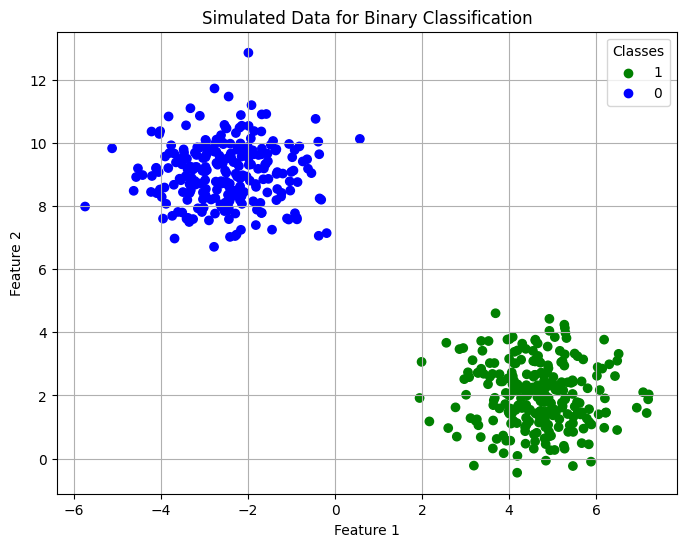

In [58]:
# Generate dataset
X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=42)

# Plotting with color coding and legend
plt.figure(figsize=(8, 6))
colors = ['green' if y_value == 1 else 'blue' for y_value in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Simulated Data for Binary Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

# Adding legend
plt.scatter([], [], c='green', label='1')
plt.scatter([], [], c='blue', label='0')
plt.legend(title="Classes")

# Show the plot
plt.show()



Implement a linear classifier by formulating and solving the optimization problem
discussed in the lecture using Gurobi. Verify whether your implementation correctly
predicts whether the dataset simulated in the previous step can be classified using a linear
classifier.

# Support Vector Machine using Scikit-learn

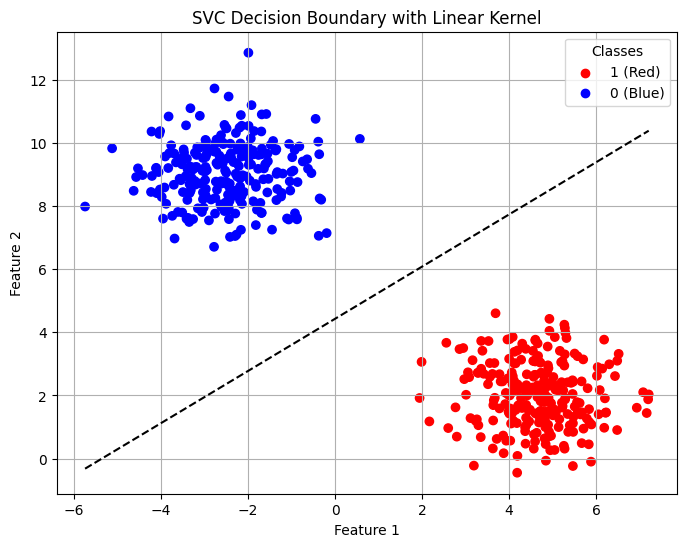

w = [ 0.28738561 -0.34766675]
b = 1.5406615553102891


In [59]:
from sklearn.svm import SVC
import numpy as np

# Train SVC
svc = SVC(kernel='linear')
svc.fit(X, y)

# Coefficients
w = svc.coef_[0]
b = svc.intercept_[0]

# Plotting
plt.figure(figsize=(8, 6))

# Plot the original data points
colors = ['red' if y_value == 1 else 'blue' for y_value in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)

# Plot the decision boundary
x_boundary = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_boundary = -(w[0]/w[1])*x_boundary - (b/w[1])
plt.plot(x_boundary, y_boundary, 'k--')

plt.title("SVC Decision Boundary with Linear Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

# Adding legend
plt.scatter([], [], c='red', label='1 (Red)')
plt.scatter([], [], c='blue', label='0 (Blue)')
plt.legend(title="Classes")

plt.show()

#printing the coefficients
print('w =', w)
print('b =', b)



# Support Vector Machine using Gurobi

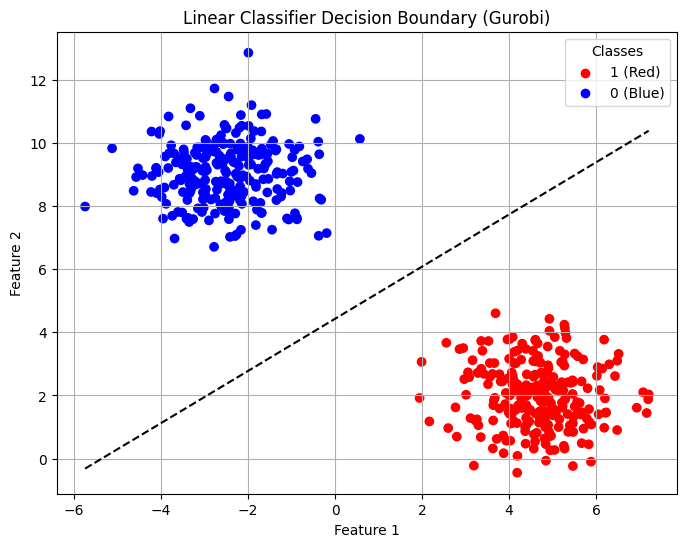

w = [0.2873414261262052, -0.3477016772488634]
b = 1.5409302965393183


In [62]:
# Function to build and solve the binary classification model


def build_and_solve_model(X, y):
    m, n = X.shape
    model = gp.Model()
    model.Params.OutputFlag = 0

    # Variables: weights for each feature and bias term
    w = model.addVars(n, lb=-GRB.INFINITY, name="w")
    b = model.addVar(lb=-GRB.INFINITY, name="b")

    # Objective: minimize the sum of squared weights (for simplicity)
    model.setObjective(gp.quicksum(w[i]*w[i] for i in range(n)), GRB.MINIMIZE)

    # Constraints: separate the classes
    for i in range(m):
        yi = 1 if y[i] == 1 else -1
        model.addConstr(yi * (gp.quicksum(w[j]*X[i, j] for j in range(n)) + b) >= 1, f"C{i}")

    # Solve the model
    model.optimize()

    # Retrieve the coefficients
    w_values = [w[i].X for i in range(n)]
    b_value = b.X

    return w_values, b_value

# Build and solve the model
w, b = build_and_solve_model(X, y)

# Plotting
plt.figure(figsize=(8, 6))

# Plot the original data points
colors = ['red' if label == 1 else 'blue' for label in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)

# Plot the decision boundary
x_boundary = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_boundary = -(w[0]/w[1])*x_boundary - b/w[1]
plt.plot(x_boundary, y_boundary, 'k--')

plt.title("Linear Classifier Decision Boundary (Gurobi)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

# Adding legend
plt.scatter([], [], c='red', label='1 (Red)')
plt.scatter([], [], c='blue', label='0 (Blue)')
plt.legend(title="Classes")

plt.show()

#printing the coefficients
print('w =', w)
print('b =', b)

